<a href="https://colab.research.google.com/github/juhumkwon/Data/blob/main/05_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5(%EB%B3%B4%EC%95%88%EC%A0%95%EC%B1%85_%ED%95%99%EC%8A%B5%EC%98%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

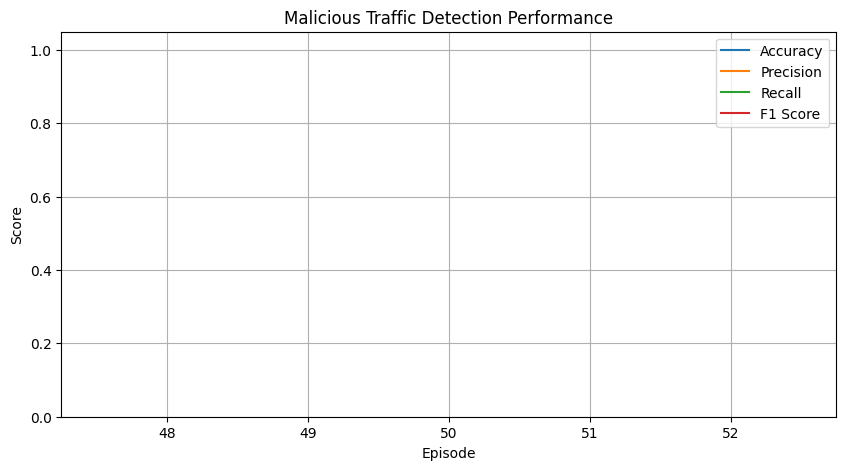

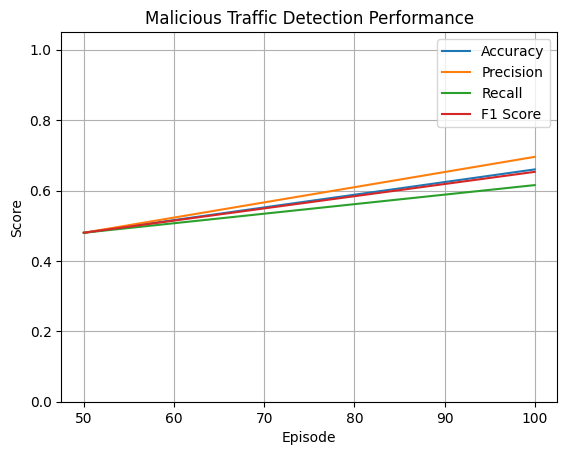

[100] Loss: 6.3887, Reward: 1.00, Accuracy: 1


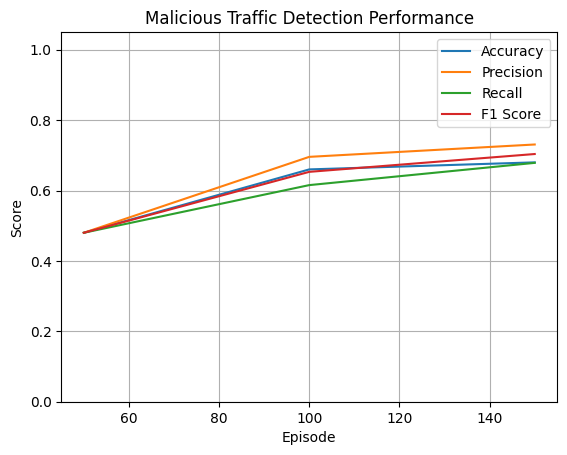

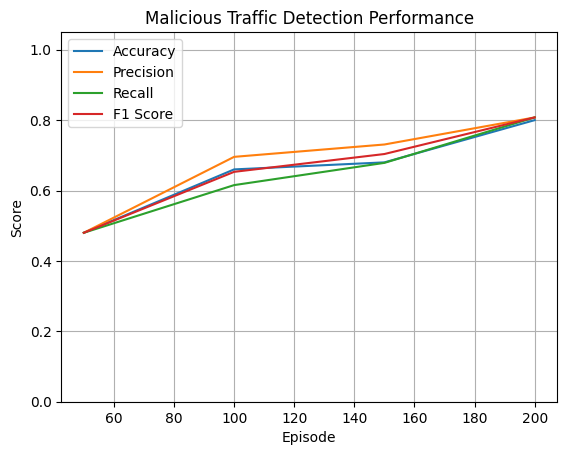

[200] Loss: 1.3767, Reward: 1.00, Accuracy: 1


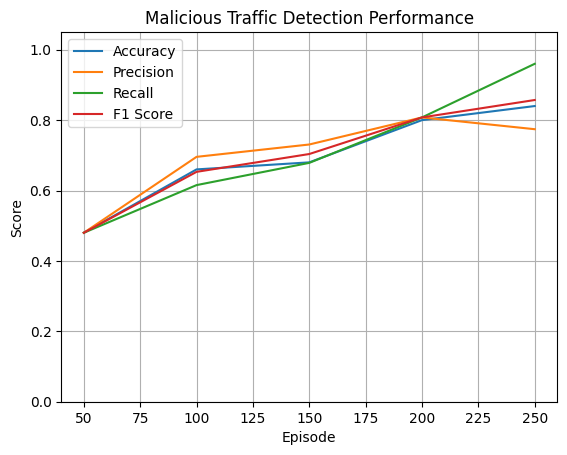

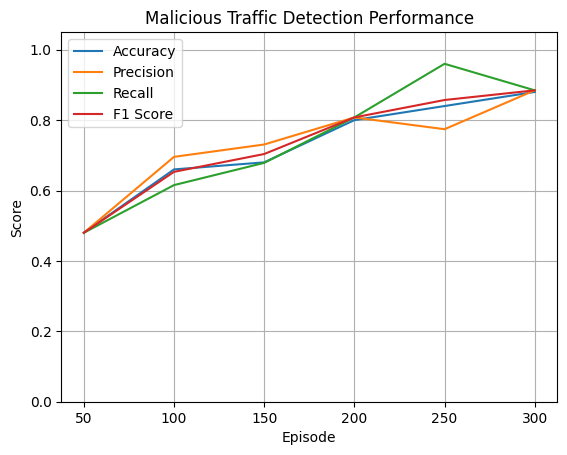

[300] Loss: 0.0515, Reward: 1.00, Accuracy: 1


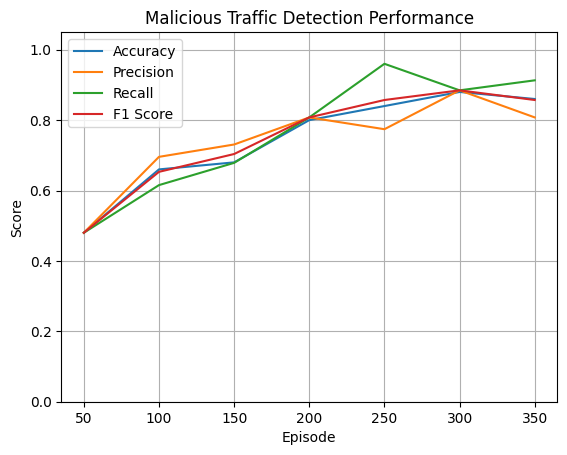

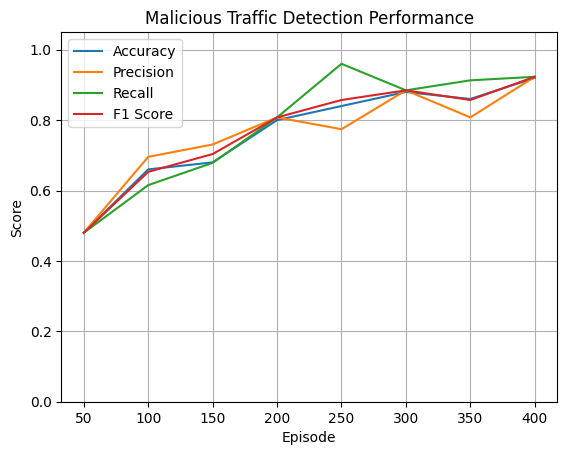

[400] Loss: 0.0311, Reward: 1.00, Accuracy: 1


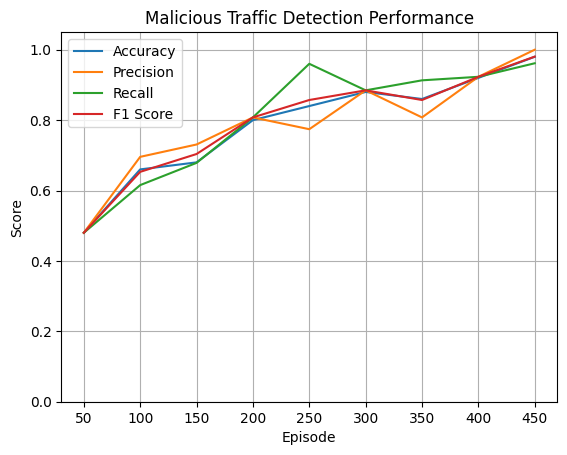

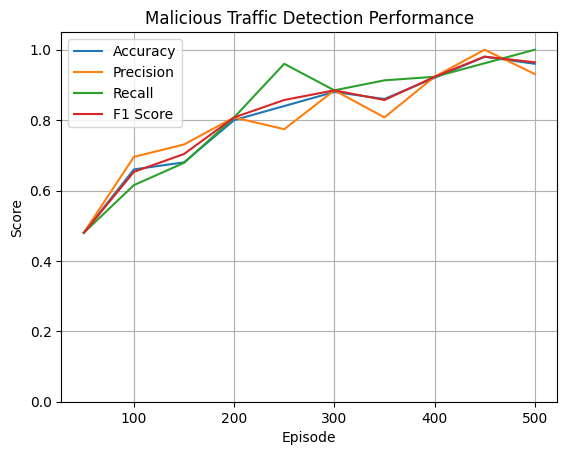

[500] Loss: 0.0075, Reward: 0.50, Accuracy: 1


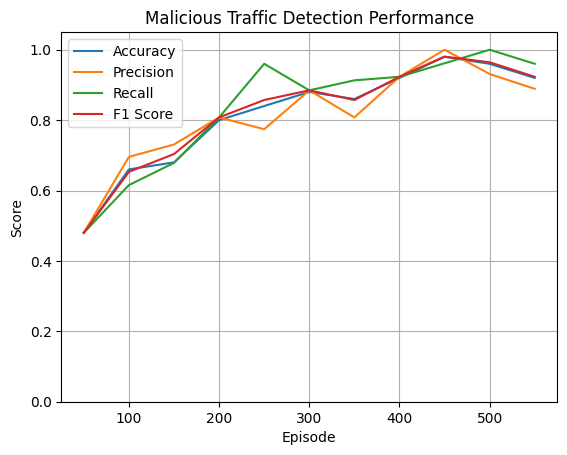

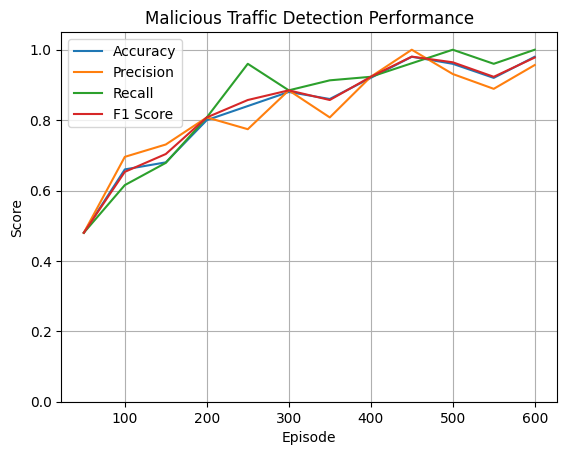

[600] Loss: 0.0054, Reward: 1.00, Accuracy: 1


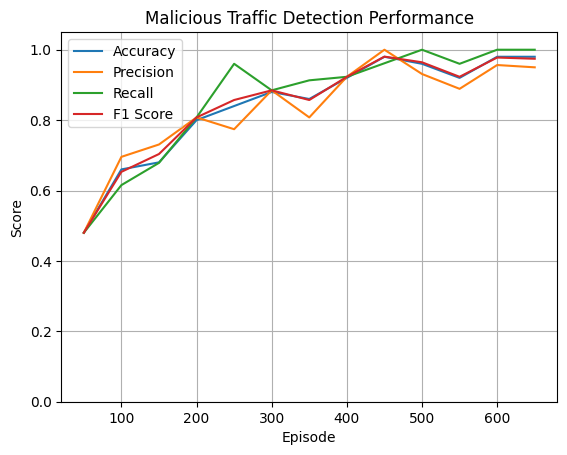

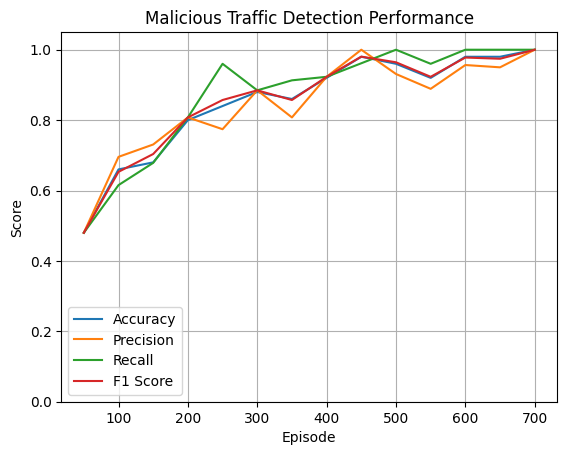

[700] Loss: 0.0053, Reward: 1.00, Accuracy: 1


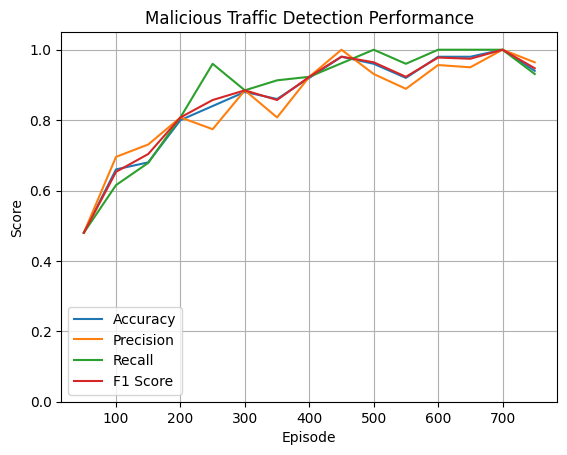

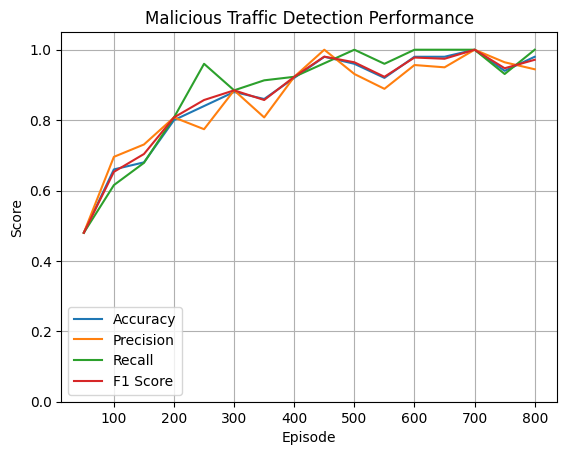

[800] Loss: 0.0029, Reward: 0.50, Accuracy: 1


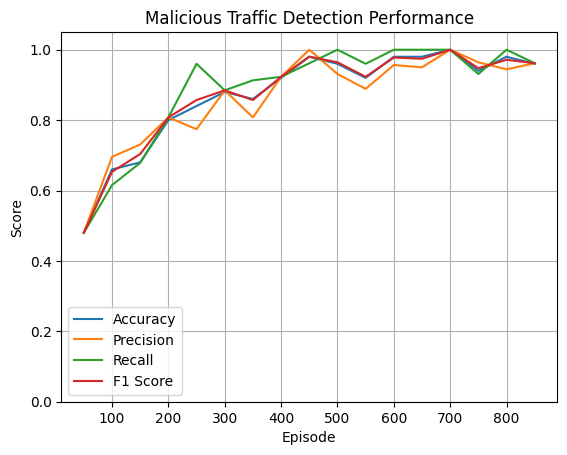

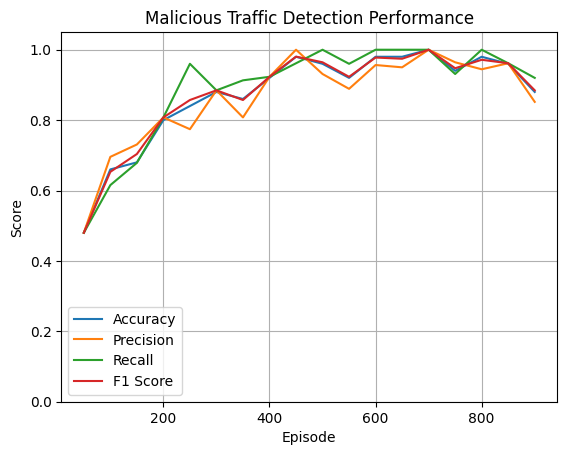

[900] Loss: 0.0028, Reward: 1.00, Accuracy: 1


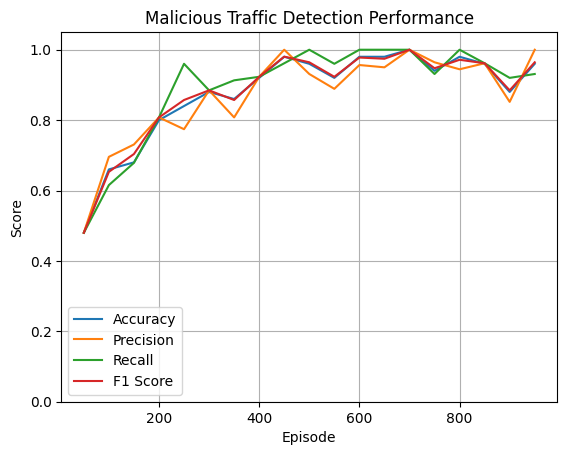

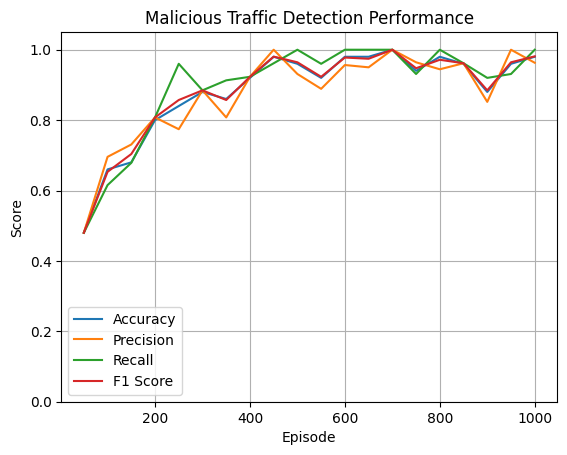

[1000] Loss: 0.0020, Reward: 0.50, Accuracy: 1


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 54728 (\N{HANGUL SYLLABLE HEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/

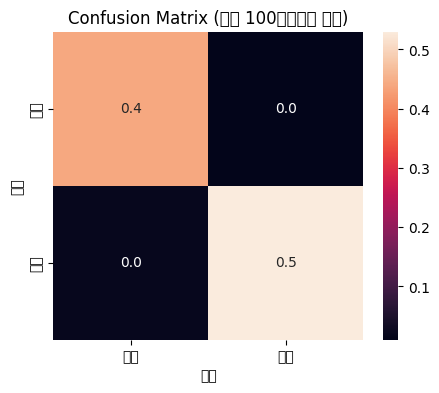

In [2]:
# colab에서 seaborn 설치가 필요할 수 있음
!pip install seaborn -q

import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

# === 환경 설정 함수 ===
def generate_traffic():
    port = np.random.choice([22, 80, 443, 3389])
    reputation = np.random.choice([0, 1])  # 0: 악성, 1: 정상
    length = np.random.randint(50, 1500)
    proto = np.random.choice([0, 1])  # 0: TCP, 1: UDP
    return np.array([port / 1000, reputation, length / 1500, proto], dtype=np.float32)

def get_reward(action, traffic):
    label = traffic[1]
    if action == 1 and label == 0: return +1
    elif action == 1 and label == 1: return -2
    elif action == 0 and label == 0: return -5
    else: return +0.5

# === Q-network 모델 생성 ===
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(4,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear')  # 2 actions: 허용/차단
    ])
    return model

# === 성능 지표 계산 함수 ===
def calculate_metrics(conf_matrix):
    TN, FP = conf_matrix[0]
    FN, TP = conf_matrix[1]

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = (TP + TN) / np.sum(conf_matrix)

    return accuracy, precision, recall, f1

# === 그래프 실시간 업데이트 함수 ===
def plot_metrics(x, acc_list, prec_list, rec_list, f1_list):
    plt.clf()
    plt.plot(x, acc_list, label='Accuracy')
    plt.plot(x, prec_list, label='Precision')
    plt.plot(x, rec_list, label='Recall')
    plt.plot(x, f1_list, label='F1 Score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.title('Malicious Traffic Detection Performance')
    plt.legend()
    plt.grid(True)
    plt.pause(0.01)

# === 하이퍼파라미터 설정 ===
gamma = 0.95
batch_size = 64
buffer_size = 10000
target_update_freq = 20
epsilon_decay = 0.995
min_epsilon = 0.1
learning_rate = 0.001
max_episodes = 1000

# === 모델 및 버퍼 초기화 ===
main_model = build_model()
target_model = build_model()
target_model.set_weights(main_model.get_weights())
optimizer = tf.keras.optimizers.Adam(learning_rate)

replay_buffer = deque(maxlen=buffer_size)

# === 로그 기록 ===
rewards_log = []
acc_log = []
conf_matrix_log = []

# === 실시간 시각화 초기화 ===
plt.figure(figsize=(10, 5))
plt.ion()
metric_episodes = []
accuracies = []
precisions = []
recalls = []
f1s = []

# === 학습 시작 ===
epsilon = 1.0
for episode in range(1, max_episodes + 1):
    state = generate_traffic()
    total_reward = 0
    correct = 0
    confusion = np.zeros((2, 2))  # [true][pred]

    # 한 에피소드 1 step (환경이 독립 샘플이라)
    if np.random.rand() < epsilon:
        action = np.random.randint(2)
    else:
        q_vals = main_model(np.expand_dims(state, axis=0)).numpy()[0]
        action = np.argmax(q_vals)

    reward = get_reward(action, state)
    next_state = generate_traffic()
    done = True

    replay_buffer.append((state, action, reward, next_state, done))
    total_reward += reward

    true_label = int(state[1] == 0)  # 악성:1, 정상:0로 변경 가능하나 여기선 0:정상,1:악성 기준
    pred_label = int(action == 1)
    if true_label == pred_label:
        correct += 1
    confusion[true_label][pred_label] += 1

    state = next_state

    # ==== 학습 ====
    if len(replay_buffer) >= batch_size:
        minibatch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions = np.array(actions)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)

        # Double DQN 타겟 계산
        next_q_main = main_model(next_states)
        next_actions = tf.argmax(next_q_main, axis=1)

        next_q_target = target_model(next_states).numpy()
        next_q_values = np.array([next_q_target[i, a] for i, a in enumerate(next_actions)])

        target_qs = rewards + gamma * next_q_values * (1 - dones)

        with tf.GradientTape() as tape:
            q_preds = main_model(states)
            chosen_qs = tf.reduce_sum(q_preds * tf.one_hot(actions, 2), axis=1)
            loss = tf.reduce_mean(tf.square(chosen_qs - target_qs))

        grads = tape.gradient(loss, main_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, main_model.trainable_variables))

    # 타깃 네트워크 업데이트
    if episode % target_update_freq == 0:
        target_model.set_weights(main_model.get_weights())

    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # 기록
    rewards_log.append(total_reward)
    acc_log.append(correct)
    conf_matrix_log.append(confusion)

    # 50 에피소드마다 성능 지표 계산 및 실시간 그래프 갱신
    if episode % 50 == 0:
        recent_conf = sum(conf_matrix_log[-50:]) / 50
        acc, prec, rec, f1 = calculate_metrics(recent_conf)
        metric_episodes.append(episode)
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

        plot_metrics(metric_episodes, accuracies, precisions, recalls, f1s)

    if episode % 100 == 0:
        print(f"[{episode}] Loss: {loss.numpy():.4f}, Reward: {total_reward:.2f}, Accuracy: {correct}")

plt.ioff()
plt.show()

# 최종 confusion matrix 시각화 (최근 100 에피소드 평균)
avg_conf_matrix = sum(conf_matrix_log[-100:]) / 100
plt.figure(figsize=(5, 4))
sns.heatmap(avg_conf_matrix, annot=True, fmt=".1f", xticklabels=['허용', '차단'], yticklabels=['정상', '악성'])
plt.title("Confusion Matrix (최근 100에피소드 평균)")
plt.xlabel("예측")
plt.ylabel("실제")
plt.show()
